In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import jacfwd
import jax_cosmo as jc
import numpy
import matplotlib.pyplot as plt

In [2]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_debug_nans", True)

In [3]:
@jit
def L_sn(wl):
    wl0=5500.
    sig2 = 1e6
    return jnp.exp(-(wl-wl0)**2/2/sig2)

In [4]:
@jit
def CCM_single(wl, Rv):
    def infrared(x, Rv):
        a = 0.574*x**1.61
        b = -0.527*x**1.61
        return a+b/Rv

    def optical(x, Rv):
        y=x-1.82
        a = 1 + 0.17699*y - 0.50447*y**2 - 0.02427*y**3 + 0.72085*y**4+ 0.01979*y**5 - 0.77530*y**6 + 0.32999*y**7
        b = 1.41338*y + 2.28305*y**2 + 1.07233*y**3 - 5.38434*y**4 - 0.62251*y**5 + 5.30260*y**6 - 2.09002*y**7
        return a+b/Rv

    def ultraviolet(x, Rv):
        a = 1.752 - 0.316*x - 0.104/((x - 4.67)**2 + 0.341)
        b = -3.090 + 1.825*x + 1.206/((x - 4.62)**2 + 0.263)
        return a+b/Rv
        
    x = 1e4/wl
    return jnp.select(condlist=[(x >= 0.3) & (x<=1.1), (x >= 1.1) & (x<=3.3), (x >= 3.3) & (x<=5.9)],
                                choicelist=[infrared(x,Rv), optical(x,Rv), ultraviolet(x,Rv)], default=0.)

In [5]:
@jit
def CCM(wl,Rv):
    return vmap(CCM_single,(0,None))(wl,Rv)

In [6]:
def flux_single(efflam, Av, Rv, z, cosmo):
    dl = (1+z)**2*jc.background.angular_diameter_distance(cosmo, 1/(1+z))
    restlam = efflam/(1+z)
    return 1/4/numpy.pi/dl**2 * L_sn(restlam) * 10**(-Av*CCM_single(restlam, Rv)/2.5)

In [7]:
def flux_lam(efflam, Av, Rv, z, cosmo):
    return vmap(flux_single,(0, None, None, None, None))(efflam, Av, Rv, z, cosmo)

In [8]:
def flux_all(efflam, Av, Rv, z, cosmo):
    return vmap(flux_lam,(None, 0, 0, 0, None))(efflam, Av, Rv, z, cosmo)

In [9]:
def lnL_cal_single(dlams, fwidth):
    # chi-sq
    calterm = jnp.sum(dlams**2*1e4) + jnp.sum((1-fwidth)**2*1e4)
    #actually lnL
    return calterm/2

In [10]:
def lnL_flux_single(Omega_c, w0, wa, dm_int, Avs, Rvs, dlams, fwidth, zs ,flux_data, dflux_data, efflam):
    cosmo = jc.Planck15(Omega_c=Omega_c, w0=w0, wa=wa)
    flux = flux_all(efflam+dlams, Avs, Rvs, zs, cosmo)
    # check this
    # flux = flux * fwidth[None,:,None]
    
    # chi-sq
    fluxterm = jnp.sum((flux_data-flux)**2 /(dflux_data**2 + (numpy.log(10)/2.5*flux*dm_int)**2))
    
    #actually lnL
    return fluxterm/2

In [16]:
def lnL(Omega_c, w0, wa, dm_int, Avs, Rvs, dlams, fwidth, zs ,flux_data, dflux_data, efflam):

    ans=0.
    for Avs_, Rvs_, dlams_, fwidth_, zs_ ,flux_data_, dflux_data_, efflam_ in zip(Avs, Rvs, dlams, fwidth, zs ,flux_data, dflux_data, efflam):
        ans += lnL_flux_single(Omega_c, w0, wa, dm_int, Avs_, Rvs_, dlams_, fwidth_, zs_ ,flux_data_, dflux_data_, efflam_)
        ans += lnL_cal_single(dlams_, fwidth_)

    return ans
    
    # cosmo = jc.Planck15(Omega_c=Omega_c, w0=w0, wa=wa)
    # flux = flux_all(efflam+dlams, Avs, Rvs, zs, cosmo)
    # # flux = flux * fwidth[None,:,None]

    # # chi-sq
    # fluxterm = jnp.sum((flux_data-flux)**2 /(dflux_data**2 + (numpy.log(10)/2.5*flux*dm_int)**2))
    # calterm = jnp.sum(dlams**2*1e4) + jnp.sum((1-fwidth)**2*1e4)
    
    # #actually lnL
    # return (fluxterm+calterm)/2

In [17]:
def partiallnL(Omega_c, w0, wa, dm_int, Avs, Rvs, dlams, fwidth, zs ,flux_data, dflux_data, efflam, argnums=None):
    return grad(lnL, argnums=argnums)(Omega_c, w0, wa, dm_int, Avs, Rvs, dlams, fwidth, zs ,flux_data, dflux_data, efflam)

In [52]:
def simulate_flux(zs, Avs, Rvs, dm_int, cosmo, dm_obs, efflam ):

    nlam = len(efflam)
    
    flux = flux_all(efflam,Avs,Rvs,zs,cosmo)

    # intrinsic dispersion
    realizeint = numpy.random.normal(0,dm_int,flux.shape[0])
    flux = flux*10**(realizeint[:,None,None]/2.5)

    # measurement uncertainty
    dflux_obs = numpy.log(10)/2.5 * flux * dm_obs
    flux = numpy.random.normal(flux, dflux_obs)
    
    return flux, dflux_obs

In [55]:
def test_simulate_flux():
    nsn = 20
    dm_obs = 0.02
    dm_int = 0.1
    cosmo = jc.Planck15()
    zs = numpy.linspace(0.1,1,nsn)
    Avs = numpy.zeros(nsn)
    # Avs = numpy.random.uniform(0,0.1,nsn)
    Rvs = numpy.zeros(nsn)+3.1
    efflam = numpy.array([4700., 6420.,  7849.])
    dlams = numpy.zeros(len(efflam))
    fwidth = numpy.zeros(len(efflam))+1.
    print(simulate_flux(zs, Avs, Rvs, dm_int, cosmo, dm_obs, efflam ))
test_simulate_flux()

(array([[[3.53139759e-07],
        [7.05971217e-07],
        [1.91094161e-07]],

       [[1.30016659e-07],
        [3.44697959e-07],
        [1.48374110e-07]],

       [[5.43693946e-08],
        [1.85235530e-07],
        [1.03151578e-07]],

       [[2.36883766e-08],
        [9.50052552e-08],
        [7.23092388e-08]],

       [[1.11894565e-08],
        [5.55395227e-08],
        [5.41781114e-08]],

       [[7.07022089e-09],
        [3.99643311e-08],
        [4.71317012e-08]],

       [[4.50627144e-09],
        [2.78512624e-08],
        [3.94015849e-08]],

       [[2.41125078e-09],
        [1.74828928e-08],
        [2.86315038e-08]],

       [[1.65250186e-09],
        [1.22612602e-08],
        [2.37172541e-08]],

       [[9.11150608e-10],
        [7.24727013e-09],
        [1.54494492e-08]],

       [[6.06653708e-10],
        [5.12109337e-09],
        [1.24058542e-08]],

       [[3.69805884e-10],
        [3.37229033e-09],
        [8.80746231e-09]],

       [[2.81710663e-10],
        [2.56

In [29]:
def fisher():

    # how many draws to approximate Fisher elements
    
    intfactor=2
    
    dm_int = 0.1
    cosmo = jc.Planck15()

    # continers for different surveys
    zs_=[]
    Avs_=[]
    Rvs_=[]
    dlams_=[]
    fwidth_=[]
    efflam_=[]

    # survey 1
    nsurvey = 1
    
    # true values of parameters
    nsn = 20
    dm_obs = 0.02
    zs = numpy.linspace(0.1,1,nsn)
    Avs = numpy.zeros(nsn)
    # Avs = numpy.random.uniform(0,0.1,nsn)
    Rvs = numpy.zeros(nsn)+3.1
    efflam = numpy.array([4700., 6420.,  7849.])
    dlams = numpy.zeros(len(efflam))
    fwidth = numpy.zeros(len(efflam))+1.

    Avs_.append(Avs)
    Rvs_.append(Rvs)
    dlams_.append(dlams)
    fwidth_.append(fwidth)
    efflam_.append(efflam)
    zs_.append(zs)
    

    
    npar = 2 + 1 * nsn + len(efflam)
    F = jnp.zeros((npar,npar))

    nsum = int(intfactor * npar)
    for i in range(nsum):
        flux_=[]
        dflux_=[]
        for Avs, Rvs, zs , efflam in zip(Avs_, Rvs_, zs_ , efflam_):
            flux, dflux = simulate_flux(zs, Avs, Rvs, dm_int, cosmo, dm_obs, efflam)
            flux_.append(flux)
            dflux_.append(dflux)
        print(lnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs_, Rvs_, 
                              dlams_, fwidth_, zs_ ,flux_, dflux_, efflam_))
        partials = partiallnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs_, Rvs_, 
                              dlams_, fwidth_, zs_ ,flux_, dflux_, efflam_, argnums=(0, 1, 4, 6))
        print(partials)
        # partials = partiallnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 
        #                       dlams, fwidth, zs ,flux, dflux, efflam, argnums=(0, 1, 4, 6))
        
        partials = jnp.hstack(partials)
        wef
        F = F + jnp.outer(partials, partials)

    F=F/nsum
    return F

In [30]:
F = fisher()

35.33952302445627
(Array(-151.3214301, dtype=float64, weak_type=True), Array(-61.78446983, dtype=float64, weak_type=True), [Array([ -9.74324176,  35.00528495, -13.87973849, -14.95585763,
         4.95364751,  12.19741075,  35.15133016,   5.63905675,
        27.40153348,  29.44797141,  20.64254904,   6.54423092,
       -19.15792585, -22.71948632,   4.62177762,  34.89684006,
        63.85276844,  59.85777139, -44.32914958,  11.08273925],      dtype=float64)], [Array([-0.04046772,  0.01105367, -0.0457057 ], dtype=float64)])


TypeError: Cannot concatenate arrays with different numbers of dimensions: got (1,), (1,), (1, 20), (1, 3).

In [26]:
jnp.linalg.matrix_rank(F)

NameError: name 'F' is not defined

In [23]:
F.shape

NameError: name 'F' is not defined

In [68]:
Finv = jnp.linalg.inv(F)

In [69]:
Finv

Array([[ 1.17628317e+00, -3.48577430e+00, -1.94584053e-01,
        -2.13552030e-01, -2.55983918e-01, -2.80114587e-01,
        -2.71155632e-01, -3.09791508e-01, -3.06446131e-01,
        -2.86283176e-01, -2.61612959e-01, -2.51864615e-01,
        -2.40414421e-01, -2.17365714e-01, -1.93600020e-01,
        -1.67632629e-01, -1.49901134e-01, -1.15332130e-01,
        -8.73844629e-02, -9.18807739e-02, -6.42486043e-02,
        -4.34433711e-02, -9.34075711e+01, -7.89001382e+01,
        -6.15418301e+01],
       [-3.48577430e+00,  1.08793649e+01,  6.61620745e-01,
         7.46246377e-01,  8.74881827e-01,  9.58649014e-01,
         9.66135344e-01,  1.08460035e+00,  1.06217797e+00,
         1.01199158e+00,  9.20039084e-01,  9.16004905e-01,
         8.86912129e-01,  7.95820851e-01,  7.51231588e-01,
         6.57478296e-01,  6.07191613e-01,  5.01649204e-01,
         4.06375956e-01,  4.15831715e-01,  3.29147722e-01,
         2.63054688e-01,  3.38708554e+02,  2.62529467e+02,
         1.72747267e+02],
    

In [19]:
zs, flux, dflux, efflam, Avs, Rvs, dm_int, cosmo = simulate_flux()

In [20]:
lnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 0., 1., zs ,flux, dflux, efflam)

Array(23.15354548, dtype=float64)

In [21]:
partials = partiallnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 0., 1., zs ,flux, dflux, efflam)
print(partials)
print(jnp.hstack(partials))

(Array(-55.46719433, dtype=float64, weak_type=True), Array(-17.24443358, dtype=float64, weak_type=True), Array(-3.58683238, dtype=float64, weak_type=True), Array(-446.57654685, dtype=float64, weak_type=True), Array([ -9.67880591, -41.84293814,   6.33656222, -11.90046755,
       -20.70561905,  38.04189149,   5.14860007,   1.94222588,
        15.86013058,  19.85769896], dtype=float64))
[ -55.46719433  -17.24443358   -3.58683238 -446.57654685   -9.67880591
  -41.84293814    6.33656222  -11.90046755  -20.70561905   38.04189149
    5.14860007    1.94222588   15.86013058   19.85769896]


In [14]:
def hessianlnL(Omega_c, w0, wa, dm_int, Avs, Rvs, dlams, fwidth, zs ,fs, fsigs, efflam):
    return jacfwd(grad(lnL))(Omega_c, w0, wa, dm_int, Avs, Rvs, dlams, fwidth, zs ,fs, fsigs, efflam)
    

In [15]:
hessianlnL(cosmo.Omega_c,cosmo.w0, cosmo.wa, dm_int, Avs, Rvs, 0., 1., zs ,flux, dflux, efflam)

Array(1201.42576679, dtype=float64, weak_type=True)

In [19]:
zs, flux, dflux, efflam, Avs, Rvs, dm_int, cosmo = simulate_flux(nsn=100)

In [24]:
dflux

array([[[1.39402158e-06],
        [9.49390326e-07],
        [6.41613781e-08]],

       [[3.26184075e-07],
        [2.15639808e-07],
        [2.30748393e-08]],

       [[1.58766705e-07],
        [1.08657878e-07],
        [1.04668614e-08]],

       [[7.56272506e-08],
        [5.42916555e-08],
        [6.46344020e-09]],

       [[4.02978119e-08],
        [3.87828165e-08],
        [5.06665019e-09]],

       [[2.58672030e-08],
        [3.03237377e-08],
        [4.21967867e-09]],

       [[2.03202517e-08],
        [1.74392100e-08],
        [2.64399000e-09]],

       [[1.31675557e-08],
        [1.57031436e-08],
        [2.94445990e-09]],

       [[1.30241081e-08],
        [1.37460348e-08],
        [2.31766052e-09]],

       [[8.07006731e-09],
        [1.12925992e-08],
        [2.28930701e-09]],

       [[7.68955913e-09],
        [8.16702159e-09],
        [1.90278734e-09]],

       [[4.68076501e-09],
        [7.92331387e-09],
        [1.64880372e-09]],

       [[4.39891480e-09],
        [6.593

<ErrorbarContainer object of 3 artists>

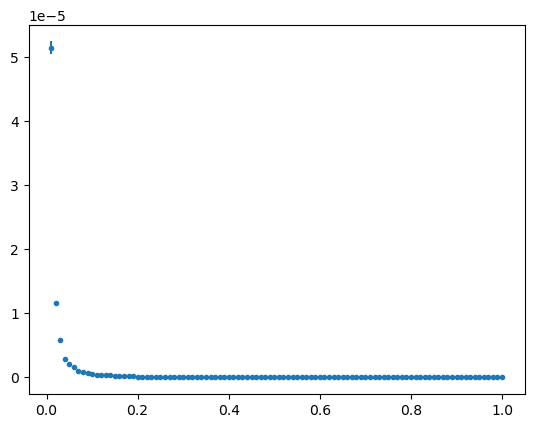

In [27]:
plt.errorbar(zs[:,None],flux[:,1,0],dflux[:,1,0],fmt='.')

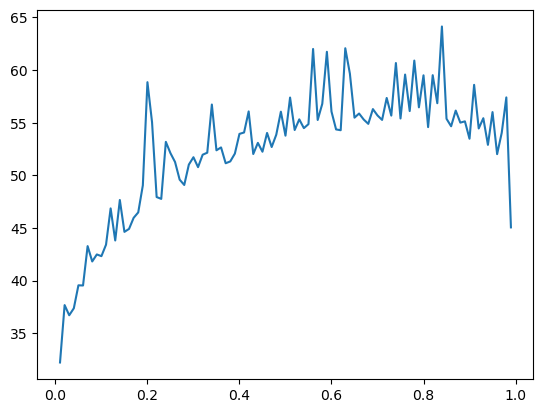

In [66]:
plt.plot(zs, -2.5*numpy.log(flux_sn(5000,Avs,Rvs,zs,cosmo)))

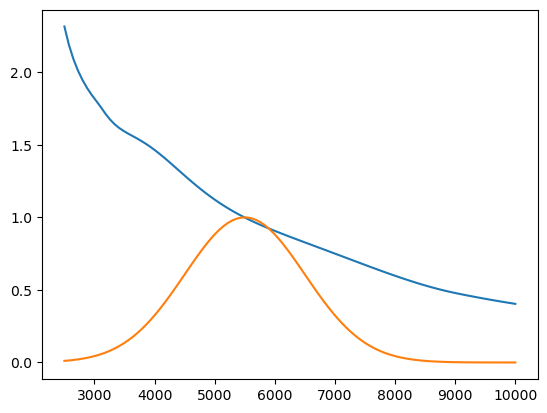

In [55]:
plt.plot(wl,CCM(wl,3.1))
plt.plot(wl,L_sn(wl))